In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from skimage import measure
from skimage.morphology import disk, opening, closing

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [3]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [4]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [5]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE= 128

In [6]:
list(os.listdir(ROOT))

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [7]:
# Train & Test set shape
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv', encoding = 'latin-1')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv', encoding = 'latin-1')
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv', encoding = 'latin-1')

print('Training data set shape.......... : ',train.shape)
print('Test data set shape...............: ',test.shape)
print('Submission data set shape.........: ',submission.shape)

Training data set shape.......... :  (1549, 7)
Test data set shape...............:  (5, 7)
Submission data set shape.........:  (730, 3)


In [8]:
train.head(),test.head()

(                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
 0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
 1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
 2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
 3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
 4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker,
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
 0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
 1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
 2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
 3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
 4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked)

Joing All Data Togather to easily application of transform

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [10]:
train.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [11]:
train['WHERE'] = 'train'
test['WHERE'] = 'val'
submission['WHERE'] = 'test'
data = train.append([test, submission])

In [12]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Patient_Week,Confidence
0,ID00007637202177411956430,-4.0,2315,58.253649,79.0,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5.0,2214,55.712129,79.0,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7.0,2061,51.862104,79.0,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9.0,2144,53.950679,79.0,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11.0,2069,52.063412,79.0,Male,Ex-smoker,train,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
725,NaN,NaN,2000,NaN,NaN,NaN,NaN,test,ID00419637202311204720264_133,100.0
726,NaN,NaN,2000,NaN,NaN,NaN,NaN,test,ID00421637202311550012437_133,100.0
727,NaN,NaN,2000,NaN,NaN,NaN,NaN,test,ID00422637202311677017371_133,100.0
728,NaN,NaN,2000,NaN,NaN,NaN,NaN,test,ID00423637202312137826377_133,100.0


In [13]:
print('Training Data:',train.info(), end = "\n\n\n")

print('Testing Data:',test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
 7   WHERE          1549 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 96.9+ KB
Training Data: None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   

In [14]:
sex_count = train["Sex"].value_counts()
sex_labels = train["Sex"].unique()

fig = px.pie(train, values=sex_count, names=sex_labels, hover_name=sex_labels,color=sex_labels,
             color_discrete_map={'Male':'blue',
                                 'Female':'pink'})
fig.show()

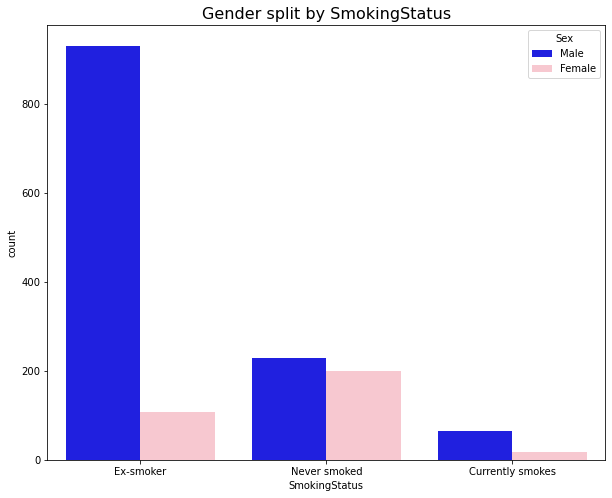

In [15]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.countplot(x='SmokingStatus', data=train, hue='Sex',palette=["blue","pink"])
plt.title('Gender split by SmokingStatus', fontsize=16)
plt.show()

In [16]:
fig = px.scatter(train, x="Percent", y="FVC", color='SmokingStatus', size='Age')
fig.show()

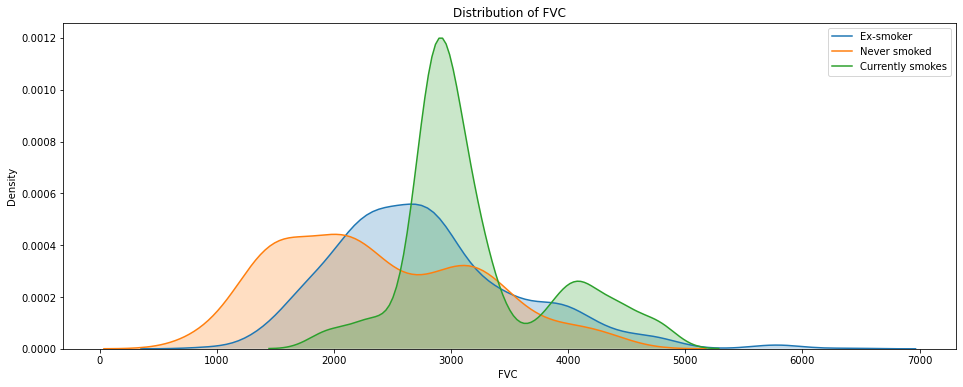

In [17]:
plt.figure(figsize=(16, 6))

sns.kdeplot(train.loc[train['SmokingStatus'] == 'Ex-smoker', 'FVC'], label = 'Ex-smoker',shade=True)
sns.kdeplot(train.loc[train['SmokingStatus'] == 'Never smoked', 'FVC'], label = 'Never smoked',shade=True)
sns.kdeplot(train.loc[train['SmokingStatus'] == 'Currently smokes', 'FVC'], label = 'Currently smokes', shade=True)

# Labeling of plot
plt.xlabel('FVC '); 
plt.ylabel('Density'); 
plt.title('Distribution of FVC');

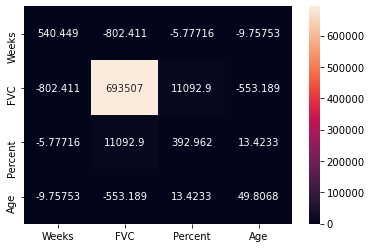

In [18]:
covMatrix = train.cov() 
sns.heatmap(covMatrix, annot=True, fmt='g')
plt.show()


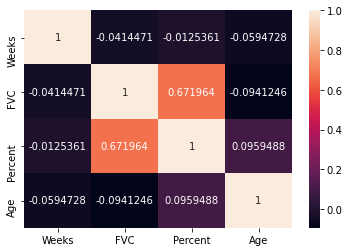

In [19]:
corrMatrix = train.corr() 
sns.heatmap(corrMatrix, annot=True, fmt='g')
plt.show()


In [20]:
#data['FVC'] = (data['FVC'] - data['FVC'].mean() ) / ( data['FVC'].std())
#data

total images for patient ID00123637202217151272140:  258


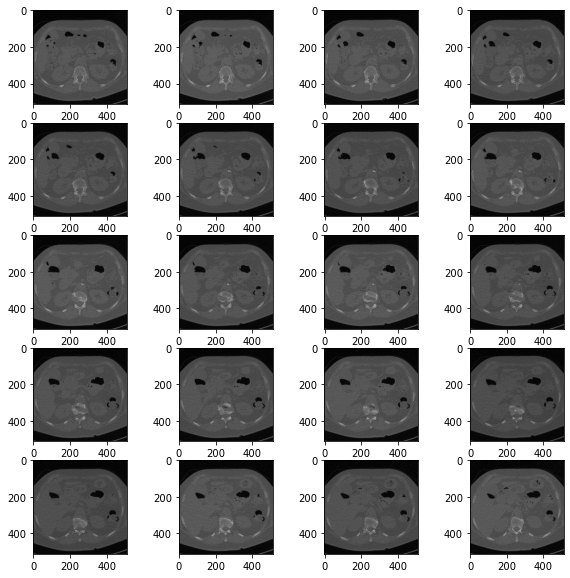

In [21]:
import pydicom
imdir = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

In [22]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)   
    
    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)
        
        background_label_1 = labels[0,0]
        background_label_2 = labels[0,-1]
        background_label_3 = labels[-1,0]
        background_label_4 = labels[-1,-1]

        binary_image[background_label_1 == labels] = 2
        binary_image[background_label_2 == labels] = 2
        binary_image[background_label_3 == labels] = 2
        binary_image[background_label_4 == labels] = 2
    
        selem = disk(4)
        binary_image = closing(binary_image, selem)
    
        binary_image -= 1 
        binary_image = 1-binary_image 
        
        segmented[n] = binary_image.copy() * image[n]
    
    return segmented


In [23]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [24]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    
    image = image.astype(np.int16)

    image[image == -2000] = 0

    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [25]:
train_dir = '../input/osic-pulmonary-fibrosis-progression/train/'
patient_ids = os.listdir(train_dir)
patient_ids = sorted(patient_ids)

In [26]:
first_patient = load_scan(train_dir + patient_ids[0])
first_patient_pixels = get_pixels_hu(first_patient)

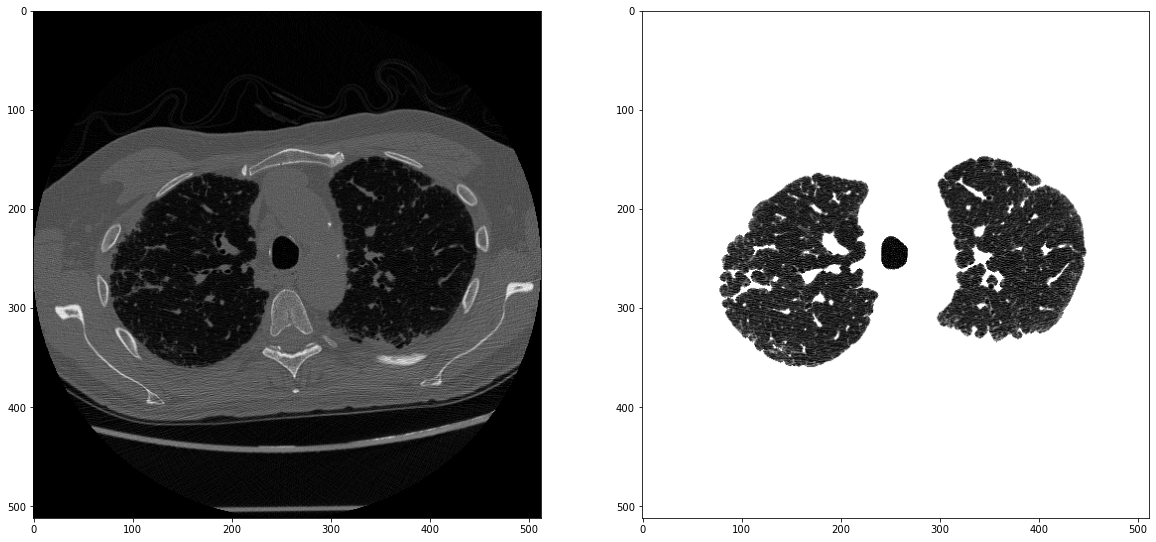

In [27]:
segmented = segment_lung_mask(np.array([first_patient_pixels[20]]))

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(first_patient_pixels[20], cmap="gray")
ax[1].imshow(segmented[0], cmap="gray")


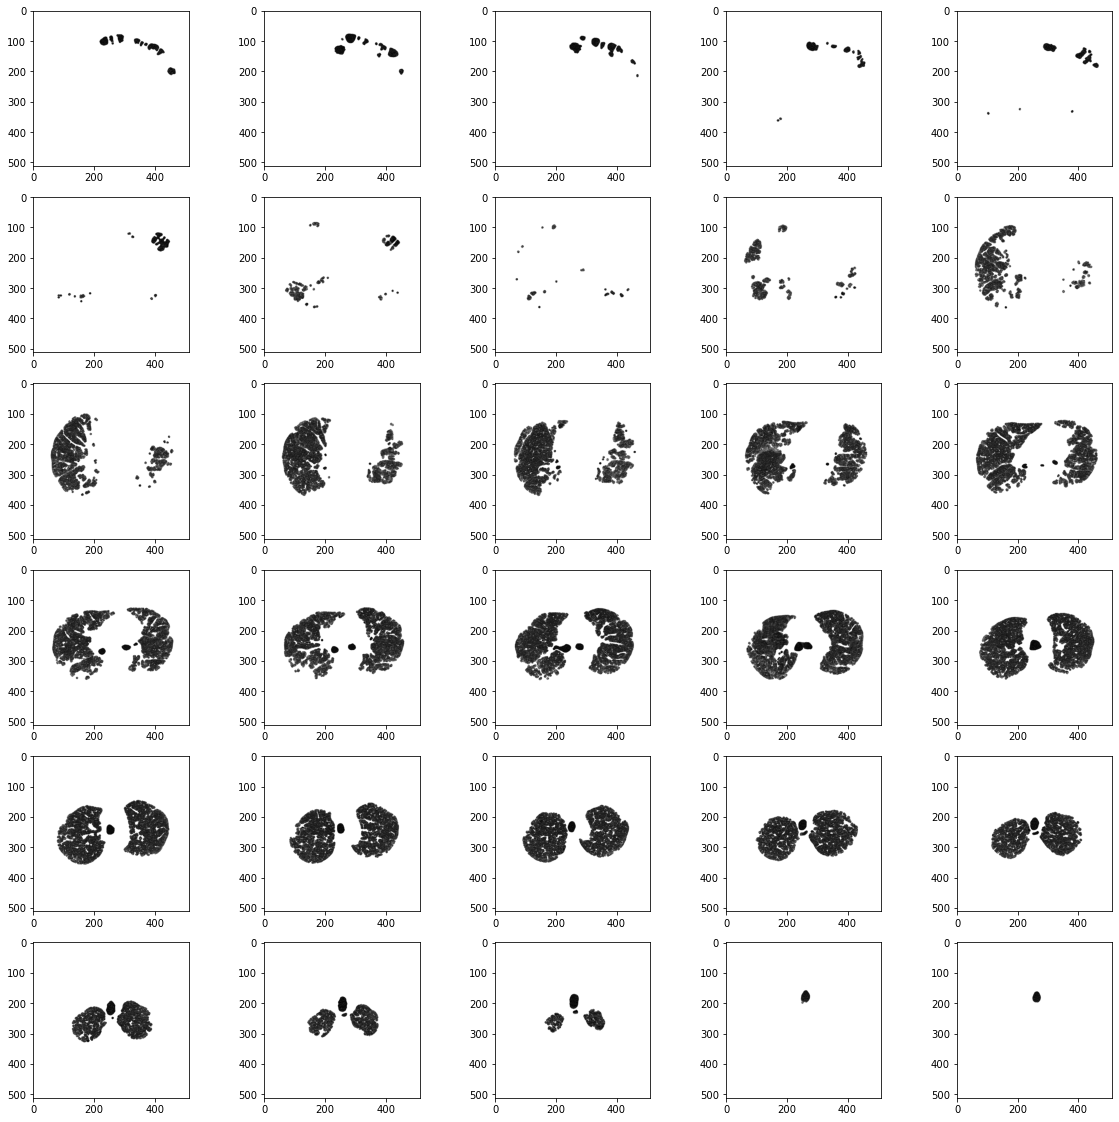

In [28]:
segmented_lungs = segment_lung_mask(first_patient_pixels)
segmented_lungs.shape
fig, ax = plt.subplots(6,5, figsize=(20,20))
for n in range(6):
    for m in range(5):
        ax[n,m].imshow(segmented_lungs[n*5+m], cmap="gray")


In [29]:
#train.reset_index(inplace = True , drop = True)
#test.reset_index(inplace = True , drop = True)

total images for patient ID00123637202217151272140:  258


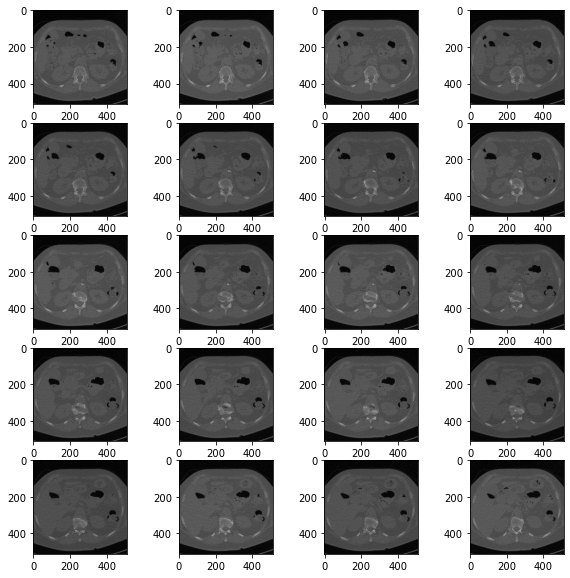

In [30]:
imdir = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

In [31]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE= 128
train = pd.read_csv(f"{ROOT}/train.csv")
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
test = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(test.drop('Weeks', axis=1), on="Patient")

add infos


In [32]:
train['WHERE'] = 'train'
test['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = train.append([test, sub])

In [33]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [34]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [35]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [36]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [37]:
data['age'] = (data['Age'] - data['Age'].mean() ) / data['Age'].std()
data['BASE'] = (data['min_FVC'] - data['min_FVC'].mean() ) /  data['min_FVC'].std()
data['week'] = (data['base_week'] - data['base_week'].mean() ) /data['base_week'].std()
data['percent'] = (data['Percent'] - data['Percent'].mean() ) / data['Percent'].std()
FE += ['age','percent','week','BASE']

In [38]:
train = data.loc[data.WHERE=='train']
test = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [39]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1535,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.684107,0.316781,-0.876447,-0.422522
1536,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,-0.109010,-0.064045,-0.876447,0.293816
1537,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.684107,-1.160443,-0.876447,-0.030741
1538,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.525484,0.688120,-0.876447,0.125497
1539,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,val,NaN,NaN,...,0.0,1,0,0,1,0,0.684107,0.188032,-0.876447,-0.323568


In [40]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0.0,1,0,1,0,0,1.635847,-0.638671,-0.876447,-1.143377
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,9.0,1,0,1,0,0,1.635847,-0.638671,-0.598881,-1.296904
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,11.0,1,0,1,0,0,1.635847,-0.638671,-0.537199,-1.529474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,13.0,1,0,1,0,0,1.635847,-0.638671,-0.475518,-1.403308
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,15.0,1,0,1,0,0,1.635847,-0.638671,-0.413836,-1.517313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,train,NaN,NaN,...,13.0,1,0,0,1,0,0.684107,0.188032,-0.475518,-0.639519
1531,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,train,NaN,NaN,...,19.0,1,0,0,1,0,0.684107,0.188032,-0.290473,-0.244951
1532,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,train,NaN,NaN,...,31.0,1,0,0,1,0,0.684107,0.188032,0.079615,-0.348784
1533,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,train,NaN,NaN,...,43.0,1,0,0,1,0,0.684107,0.188032,0.449704,-0.249401


In [41]:
initializer = tf.keras.initializers.GlorotNormal()

In [42]:
L.LSTM(25,kernel_initializer=initializer)

In [43]:
import tensorflow as tf

In [44]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)
#=================
def make_model():
    z = L.Input((9,), name="Patient")
    y = L.LSTM(25, kernel_initializer=initializer, return_sequences=True)(tf.expand_dims(z, axis=-1))
    y = L.LSTM(25, kernel_initializer=initializer,return_sequences=True)(y)
    y = L.Reshape([25*9])(y)
    x = L.Dense(100,kernel_initializer=initializer, activation="relu", name="d1")(y)
    x = L.Dense(100,kernel_initializer=initializer, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    #model.compile(loss=tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM), optimizer=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model


In [45]:
net=make_model()
NFOLD = 6
kf = KFold(n_splits=NFOLD)

In [46]:
y = train['FVC'].values
z = train[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))


In [47]:
%%time
cnt = 0
i = 0
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model()
    history=net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=800, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    val_score = net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE)
    print("val", val_score)
    print("predict val...")
    print("predict test...")
    if val_score[1] < 6.8:
        pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
        pe = pe*i
        pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0)
        i+=1
        pe = pe/i

FOLD 1
train [34.673866271972656, 6.317236423492432]
val [47.27716064453125, 6.603555679321289]
predict val...
predict test...
FOLD 2
train [34.723941802978516, 6.3541035652160645]
val [45.09327697753906, 6.585416793823242]
predict val...
predict test...
FOLD 3
train [32.25247573852539, 6.2193498611450195]
val [62.20225524902344, 7.242844104766846]
predict val...
predict test...
FOLD 4
train [33.90559768676758, 6.2902703285217285]
val [55.86858367919922, 6.912852764129639]
predict val...
predict test...
FOLD 5
train [40.14453887939453, 6.508702278137207]
val [44.97846221923828, 6.614007949829102]
predict val...
predict test...
FOLD 6
train [31.239131927490234, 6.1833086013793945]
val [49.14127731323242, 6.66616153717041]
predict val...
predict test...
CPU times: user 21min 30s, sys: 2min 25s, total: 23min 55s
Wall time: 12min 48s


In [48]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

1015.5845786625865 136.2545191463508


In [49]:
## FIND OPTIMIZED STANDARD-DEVIATION
sigma_opt = mean_absolute_error(y, pred[:,1])
sigma_uncertain = pred[:,2] - pred[:,0]
sigma_mean = np.mean(sigma_uncertain)
print(sigma_opt, sigma_mean)

1015.5845786625865 136.2545191463508


In [50]:
y[1],pred[1,1],pred[1,0],pred[1,2]

(2214, 2019.3603515625, 1930.9971923828125, 2117.68896484375)

In [51]:
pred,y

(array([[1992.3104248 , 2080.99560547, 2179.35083008],
        [1930.99719238, 2019.36035156, 2117.68896484],
        [1762.80883789, 1849.07006836, 1945.4432373 ],
        ...,
        [2539.59375   , 2637.86157227, 2746.73095703],
        [2554.16992188, 2652.77612305, 2762.66992188],
        [2456.22460938, 2554.44384766, 2665.07275391]]),
 array([2315, 2214, 2061, ..., 2908, 2975, 2774]))

In [52]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0.0,1,0,1,0,0,1.635847,-0.638671,-0.876447,-1.143377
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,9.0,1,0,1,0,0,1.635847,-0.638671,-0.598881,-1.296904
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,11.0,1,0,1,0,0,1.635847,-0.638671,-0.537199,-1.529474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,13.0,1,0,1,0,0,1.635847,-0.638671,-0.475518,-1.403308
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,15.0,1,0,1,0,0,1.635847,-0.638671,-0.413836,-1.517313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,train,NaN,NaN,...,13.0,1,0,0,1,0,0.684107,0.188032,-0.475518,-0.639519
1531,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,train,NaN,NaN,...,19.0,1,0,0,1,0,0.684107,0.188032,-0.290473,-0.244951
1532,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,train,NaN,NaN,...,31.0,1,0,0,1,0,0.684107,0.188032,0.079615,-0.348784
1533,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,train,NaN,NaN,...,43.0,1,0,0,1,0,0.684107,0.188032,0.449704,-0.249401


In [53]:
print(pred[6,1],y[6])

2048.917236328125 2000


In [54]:
y

array([2315, 2214, 2061, ..., 2908, 2975, 2774])

In [55]:
pred

array([[1992.3104248 , 2080.99560547, 2179.35083008],
       [1930.99719238, 2019.36035156, 2117.68896484],
       [1762.80883789, 1849.07006836, 1945.4432373 ],
       ...,
       [2539.59375   , 2637.86157227, 2746.73095703],
       [2554.16992188, 2652.77612305, 2762.66992188],
       [2456.22460938, 2554.44384766, 2665.07275391]])

In [56]:
pred[:,2]

array([2179.35083008, 2117.68896484, 1945.4432373 , ..., 2746.73095703,
       2762.66992188, 2665.07275391])

In [57]:
y

array([2315, 2214, 2061, ..., 2908, 2975, 2774])

In [58]:
pred[:,1]

array([2080.99560547, 2019.36035156, 1849.07006836, ..., 2637.86157227,
       2652.77612305, 2554.44384766])

In [59]:
pred[:, 0]

array([1992.3104248 , 1930.99719238, 1762.80883789, ..., 2539.59375   ,
       2554.16992188, 2456.22460938])

(746.5779852836533, 11075.511590169537, 891.2509381337459, 11220.18454301963)

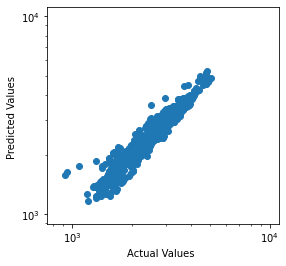

In [60]:
g=plt.scatter(y , pred[:, 1])

g.axes.set_yscale('log')
g.axes.set_xscale('log')

g.axes.set_xlabel('Actual Values ')
g.axes.set_ylabel('Predicted Values ')
g.axes.axis('equal')
g.axes.axis('square')


>2315.0, 2081.0 = 234.004
>2214.0, 2019.4 = 194.640
>2061.0, 1849.1 = 211.930
>2144.0, 1982.7 = 161.346
>2069.0, 1911.3 = 157.732
>2101.0, 2025.0 = 76.048
>2000.0, 2048.9 = 48.917
>2064.0, 2151.6 = 87.637
>2057.0, 2082.6 = 25.565
>3660.0, 3474.2 = 185.784
>3610.0, 3452.2 = 157.772
>3895.0, 3546.4 = 348.643
>3759.0, 3489.9 = 269.104
>3639.0, 3435.0 = 204.020
>3578.0, 3381.6 = 196.436
>3625.0, 3371.1 = 253.936
>3390.0, 3272.2 = 117.754
>3214.0, 3237.1 = 23.066
>3523.0, 3556.1 = 33.066
>3373.0, 3529.2 = 156.183
>3327.0, 3521.7 = 194.749
>2993.0, 3403.2 = 410.182
>3030.0, 3414.0 = 384.041
>3103.0, 3431.6 = 328.617
>2993.0, 3347.2 = 354.222
>2474.0, 3031.2 = 557.238
>2518.0, 3059.9 = 541.893
>3326.0, 3197.6 = 128.353
>3419.0, 3238.7 = 180.311
>3541.0, 3292.6 = 248.376
>3502.0, 3267.0 = 234.956
>3410.0, 3211.8 = 198.237
>3477.0, 3225.4 = 251.624
>3269.0, 3074.0 = 195.010
>3346.0, 3104.8 = 241.201
>3193.0, 3045.7 = 147.265
>3418.0, 3442.1 = 24.112
>3759.0, 3518.6 = 240.354
>3276.0, 3421.4 = 1

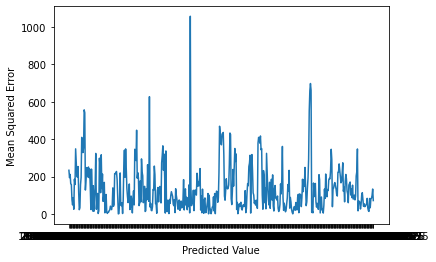

In [61]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
errors = list()
for i in range(500):
	# calculate error
	err = abs(y[i] - pred[i, 1])
	# store error
	errors.append(err)
	# report error
	print('>%.1f, %.1f = %.3f' % (y[i], pred[i, 1], err))
# plot errors
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))], labels=pred[:,1])
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Mean Squared Error')
pyplot.show()

In [62]:
y.shape

(1535,)

In [63]:
pred[:,1].shape

(1535,)

In [64]:
z=pred[:,1]

In [65]:
# import scipy
# import scipy.stats
# scipy.stats.chisquare(z,f_exp=y)

In [66]:
p = 0
DOF = len(y) - p - 1
scipy.stats.chi2.ppf(0.95, DOF) 

NameError: name 'scipy' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error
import math
print(mean_squared_error(y[:500], z[:500]))
print(math.sqrt(mean_squared_error(y[:500], z[:500])))
print(mean_absolute_error(y[:500],z[:500]))
print(np.mean(np.abs((y[:500] - z[:500])/y[:500]))*100)

In [ ]:
plt.plot(y - pred[:, 1],marker='o',linestyle='-')

In [ ]:
# fetch results from history
score = history.history['score']
val_score = history.history['val_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(800)

# create subplots
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, score, label = 'Training Accuracy')
plt.plot(epochs_range, val_score, label = 'Validation Accuracy')
# limit y-values for better zoom-scale. Remember that roughly -4.5 is the best possible score
# plt.ylim(0.8 * np.mean(val_score), 1.2 * np.mean(val_score))
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
# limit y-values for beter zoom-scale
plt.ylim(0.3 * np.mean(val_loss), 1.8 * np.mean(val_loss))

plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y , pred[:, 1], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(pred[:, 1]), max(y))
p2 = min(min(pred[:, 1]), min(y ))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()